In [1]:
import torch
import struct
import numpy as np
import matplotlib.pyplot as plt
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from torch.cuda.amp import autocast

# device = "cuda" if torch.cuda.is_available() else "cpu"
device_vggt = "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model_vggt = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model_vggt.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
model_vggt.to(device_vggt)

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [3]:
SCENE="bicycle"
SKIP=25

if SCENE=="banana": 
    # Load and preprocess example images (replace with your own image paths)
    image_names = [
        "/home/skhalid/Documents/data/banana/input/frame_00001.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00002.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00003.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00004.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00005.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00006.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00007.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00008.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00009.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00010.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00011.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00012.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00013.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00014.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00015.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00016.JPG"
    ]
    ### BANANA
    width = 3008
    height = 2000
    BASE_PATH = "/home/skhalid/Documents/data/banana"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "frame_"
    START_ID = 0
    N = 200_000

elif SCENE=="lego": 
    ### LEGO
    image_names = ["/home/skhalid/Documents/data/nerf_synthetic/lego/train/r_"+str(v)+".png" for v in range(0, 99, SKIP)]
    width = 800
    height = 800
    BASE_PATH = "/home/skhalid/Documents/data/nerf_synthetic/lego/"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "r_"
    START_ID = 0
    N = 200_000

elif SCENE=="bicycle": 
    ### BICYCLE
    BASE="/home/skhalid/Documents/data/360_v2/bicycle/images_4/_DSC"
    image_names = [BASE+str(v)+".JPG" for v in range(8679, 8873, SKIP)]
    width = 1236
    height = 821    
    BASE_PATH = "/home/skhalid/Documents/data/360_v2/bicycle"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "_DSC"
    START_ID = 0
    N = 1_000_000
    # test_cases = ["8679.JPG",
    #               "8687.JPG",
    #               "8695.JPG",
    #               "8703.JPG",
    #               "8711.JPG",
    #               "8719.JPG",
    #               "8727.JPG",
    #               "8735.JPG",
    #               "8744.JPG",
    #               "8752.JPG",
    #               "8760.JPG",
    #               "8768.JPG",
    #               "8776.JPG",
    #               "8784.JPG",
    #               "8792.JPG",
    #               "8800.JPG",
    #               "8808.JPG",
    #               "8816.JPG",
    #               "8824.JPG",
    #               "8832.JPG",
    #               "8840.JPG",
    #               "8848.JPG",
    #               "8856.JPG",
    #               "8864.JPG",
    #               "8872.JPG"]
    # for test_case in test_cases:
    #     image_names.append(BASE+str(test_case))

elif SCENE=="truck": 
    ### BICYCLE
    BASE="/home/skhalid/Documents/data/tandt_db/tandt/truck/images/"
    image_names = [BASE+str(v).zfill(6)+".jpg" for v in range(1, 252, SKIP)]
    width = 1957
    height = 1091    
    BASE_PATH = "/home/skhalid/Documents/data/tandt_db/tandt/truck"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = ""
    START_ID = 0
    N = 1_000_000
    # test_cases = ["8679.JPG",
    #               "8687.JPG",
    #               "8695.JPG",
    #               "8703.JPG",
    #               "8711.JPG",
    #               "8719.JPG",
    #               "8727.JPG",
    #               "8735.JPG",
    #               "8744.JPG",
    #               "8752.JPG",
    #               "8760.JPG",
    #               "8768.JPG",
    #               "8776.JPG",
    #               "8784.JPG",
    #               "8792.JPG",
    #               "8800.JPG",
    #               "8808.JPG",
    #               "8816.JPG",
    #               "8824.JPG",
    #               "8832.JPG",
    #               "8840.JPG",
    #               "8848.JPG",
    #               "8856.JPG",
    #               "8864.JPG",
    #               "8872.JPG"]
    # for test_case in test_cases:
    #     image_names.append(BASE+str(test_case))


In [4]:
import torch
from tqdm import tqdm

def run_batched_camera_inference(model, image_names, batch_size=8, device='cuda', dtype=torch.float16):
    from vggt.utils.pose_enc import pose_encoding_to_extri_intri
    from vggt.utils.geometry import unproject_depth_map_to_point_map
    # from vggt.utils.io import load_and_preprocess_images

    all_extrinsics = []
    all_intrinsics = []
    all_world_points = []
    depth_maps = []
    depth_conf_maps = []
    batch_tensors = []
    agg_tokens_tensor = torch.Tensor([]).to(device)
    ps_idx_list = []

    # Batch the rest of the images
    print(f"Processing the rest of {len(image_names)} images in batches of {batch_size}...")
    for i in tqdm(range(0, len(image_names), batch_size)):
        batch_names = image_names[i:i + batch_size]
        batch_tensor = load_and_preprocess_images(batch_names).to(device)

        if i==0:
            first_image = batch_tensor[0]
            print("first_image.shape: {}".format(batch_tensor.shape))
        else:
            # Add the first reference image to this batch as well
            batch_tensor = torch.cat((first_image[None], batch_tensor), dim=0)

        with torch.no_grad(), torch.cuda.amp.autocast(dtype=dtype):
            batch_tensor = batch_tensor[None]  # Add batch dim
            agg_tokens, ps_idx = model.aggregator(batch_tensor)

            pose_enc = model.camera_head(agg_tokens)[-1]
            extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, batch_tensor.shape[-2:])

            depth_map, depth_conf_map = model.depth_head(agg_tokens, batch_tensor, ps_idx)
            
            point_map_unproj = unproject_depth_map_to_point_map(depth_map.squeeze(0), extrinsic.squeeze(0), intrinsic.squeeze(0))
    
            # if i==0:    
            #     print("batch: {} | point_map_unproj.shape: {}".format(i, point_map_unproj.shape))
            # else:
            #     print("batch: {} | point_map_unproj[1:, ...].shape: {}".format(i, point_map_unproj[1:, ...].shape))

            # ==== USAGE ====
            # Inputs
            # mask: binary torch.Tensor of shape (H, W)
            # images: list of images (B, C, H, W) — assume 1 scene for simplicity
            agg_tokens = torch.stack(agg_tokens)

            if i==0:
                all_extrinsics.append(extrinsic[0, ...])
                all_intrinsics.append(intrinsic[0, ...])
                all_world_points.append(point_map_unproj)
                depth_maps.append(depth_map[0, ...])
                depth_conf_maps.append(depth_conf_map[0, ...])
                batch_tensors.append(batch_tensor[0, ...])
                agg_tokens_tensor = torch.cat((agg_tokens_tensor, agg_tokens), dim=0)
                ps_idx_list.append(ps_idx)
            else:
                all_extrinsics.append(extrinsic[0, 1:])
                all_intrinsics.append(intrinsic[0, 1:])
                all_world_points.append(point_map_unproj[1:, ...])
                depth_maps.append(depth_map[0, 1:, ...])
                depth_conf_maps.append(depth_conf_map[0, 1:, ...])
                batch_tensors.append(batch_tensor[0, 1:, ...])
                agg_tokens_tensor = torch.cat((agg_tokens_tensor, agg_tokens), dim=0)
                ps_idx_list.append(ps_idx)

            # print("extrinsic: {}".format(extrinsic.shape))
            # print("intrinsic: {}".format(intrinsic.shape))
            # print("point_map_unproj: {}".format(point_map_unproj.shape))
            # print("depth_map: {}".format(depth_map.shape))
            # print("depth_conf_map: {}".format(depth_conf_map.shape))
            # print("batch_tensor: {}".format(batch_tensor.shape))

    # Stack everything
    batch_tensors = torch.cat(batch_tensors)  # [N, 4, 4]
    all_extrinsics = torch.cat(all_extrinsics)  # [N, 4, 4]
    all_intrinsics = torch.cat(all_intrinsics)  # [N, 3, 3]
    all_world_points = np.concatenate(all_world_points)  # [N, H, W, 3]
    depth_maps = torch.cat(depth_maps, dim=0)  # [N, H, W, 3]
    depth_conf_maps = torch.cat(depth_conf_maps, dim=0)  # [N, H, W, 3]
    # aggregated_tokens_list = torch.cat(aggregated_tokens_list, dim=0)  # [N, H, W, 3]
    # ps_idx_list = torch.cat(ps_idx_list, dim=0)  # [N, H, W, 3]

    return {
        "all_extrinsics": all_extrinsics, 
        "all_intrinsics": all_intrinsics, 
        "all_world_points": all_world_points,
        "depth_maps": depth_maps,
        "depth_conf_maps": depth_conf_maps,
        "all_images": batch_tensors,
        "aggregated_tokens_list": agg_tokens_tensor,
        "ps_idx_list": ps_idx_list
    }

    # # Predict Tracks
    # # choose your own points to track, with shape (N, 2) for one scene
    # query_points = torch.FloatTensor([[100.0, 200.0], 
    #                                     [60.72, 259.94]]).to(device)
    # track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])

In [5]:
BATCH_SIZE=10

predictions = run_batched_camera_inference(model_vggt, image_names, device=device_vggt, batch_size=BATCH_SIZE)

Processing the rest of 8 images in batches of 10...


  0%|          | 0/1 [00:00<?, ?it/s]

first_image.shape: torch.Size([8, 3, 350, 518])


/tmp/ipykernel_256424/1998803155.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=dtype):


5 None None
torch.Size([1, 8, 925, 2048])
tensor([[[[ 0.1259,  0.1244, -0.2035,  ..., -0.0134,  0.0438,  0.2083],
          [ 0.3009,  0.1051, -0.2932,  ..., -0.0378, -0.0317,  0.1899],
          [ 0.2893,  0.1372, -0.2837,  ..., -0.0229, -0.0321,  0.1597],
          ...,
          [ 0.1599,  0.0303,  0.0073,  ...,  0.0337,  0.0842,  0.0848],
          [ 0.2834,  0.2385, -0.0604,  ...,  0.0200,  0.0172,  0.1497],
          [ 0.1142,  0.0102, -0.0569,  ...,  0.0737,  0.0645,  0.1010]],

         [[ 0.0818,  0.1083, -0.0269,  ...,  0.1343,  0.0527,  0.0195],
          [ 0.0761,  0.0978, -0.0468,  ...,  0.1558,  0.0557,  0.0360],
          [ 0.0828,  0.0317, -0.0435,  ...,  0.0844, -0.0303,  0.0932],
          ...,
          [ 0.0958, -0.0318, -0.0786,  ...,  0.1201, -0.0674,  0.0840],
          [-0.0763,  0.1382,  0.0206,  ...,  0.2143,  0.1689,  0.0726],
          [ 0.0262, -0.0609, -0.1491,  ...,  0.1326,  0.0061,  0.1204]],

         [[ 0.2076,  0.0749, -0.1057,  ..., -0.0732,  0.0327

100%|██████████| 1/1 [00:24<00:00, 24.49s/it]


In [6]:
all_extrinsics = predictions["all_extrinsics"].cpu().numpy()
all_intrinsics = predictions["all_intrinsics"].cpu().numpy()
all_world_points = predictions["all_world_points"]
depth_maps = predictions["depth_maps"].cpu().numpy()
depth_conf_maps = predictions["depth_conf_maps"].cpu().numpy()
all_images = predictions["all_images"].cpu().numpy()
ps_idx_list = predictions["ps_idx_list"]
aggregated_tokens_tensor = predictions["aggregated_tokens_list"]
# ps_idx_list = predictions["ps_idx_list"].cpu().numpy()

print(all_extrinsics.shape, all_intrinsics.shape, all_world_points.shape, depth_maps.shape, depth_conf_maps.shape, all_images.shape, aggregated_tokens_tensor.shape)

(8, 3, 4) (8, 3, 3) (8, 350, 518, 3) (8, 350, 518, 1) (8, 350, 518) (8, 3, 350, 518) torch.Size([24, 1, 8, 930, 2048])


In [7]:
torch.cuda.empty_cache()

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def mask_to_query_points(mask, max_points=100):
    """
    Convert a binary mask to a list of query points (N, 2)
    """
    mask = mask.astype(np.uint8)
    coords = np.column_stack(np.where(mask > 0))  # shape: (N, 2) as (row, col)
    if coords.shape[0] == 0:
        raise ValueError("No foreground pixels found in mask.")
    
    # Subsample if too many points
    if coords.shape[0] > max_points:
        idx = np.random.choice(len(coords), max_points, replace=False)
        coords = coords[idx]

    # Flip from (row, col) to (x, y)
    query_points = torch.FloatTensor(coords[:, [1, 0]])  # (N, 2)
    return query_points

#track_list: torch.Size([4, 1, 8, 50, 2])
def visualize_tracks(all_images, track_list, ps_idx_list, radius=2):
    """
    Visualize tracked points on image sequence.
    
    all_images: (T, 3, H, W) NumPy array
    track_list: (T, 1, N, 2) torch.Tensor
    ps_idx_list: (N, 2) torch.Tensor or NumPy array
    """
    T = all_images.shape[0]
    N = ps_idx_list.shape[0]

    # Normalize images if necessary
    if all_images.max() <= 1.0:
        all_images = (all_images * 255).astype(np.uint8)
    else:
        all_images = all_images.astype(np.uint8)

    # Generate unique colors
    colors = plt.cm.jet(np.linspace(0, 1, N))[:, :3] * 255

    for t in range(T):
        # Convert image to (H, W, 3) and transpose channels
        img = np.transpose(all_images[t], (1, 2, 0)).copy()  # (H, W, 3)

        for i in range(N):
            point = track_list[1, 0, t, i].detach().cpu().numpy()
            if np.any(np.isnan(point)) or np.any(np.isinf(point)):
                continue
            # x, y = int(round(point[0])), int(round(point[1]))
            x, y = int(round(float(point[0]))), int(round(float(point[1])))
            color = tuple(map(int, colors[i]))
            cv2.circle(img, (x, y), radius, color, -1)

        plt.imshow(img)
        plt.title(f"Frame {t}")
        plt.axis("off")
        plt.show()

In [9]:
'''
OBJECT_MASKING
'''
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load OWL-ViT
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14").to(device)
processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")

# Load SAM
sam_checkpoint = "/home/skhalid/Downloads/sam_vit_l.pth"
sam = sam_model_registry["vit_l"](checkpoint=sam_checkpoint).to(device).eval()
predictor = SamPredictor(sam)

/home/skhalid/Documents/vggt/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/skhalid/Documents/vggt/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


bicycle: 0.71 at box [123  70 399 246]
query_points.shape: torch.Size([1000, 2])
all_images.shape: (8, 3, 350, 518)
ps_idx_list: [5]
aggregated_tokens_tensor: torch.Size([24, 1, 8, 930, 2048])
5 None None
torch.Size([1, 8, 925, 2048])
tensor([[[[ 0.1259,  0.1244, -0.2035,  ..., -0.0134,  0.0438,  0.2083],
          [ 0.3009,  0.1051, -0.2932,  ..., -0.0378, -0.0317,  0.1899],
          [ 0.2893,  0.1372, -0.2837,  ..., -0.0229, -0.0321,  0.1597],
          ...,
          [ 0.1599,  0.0303,  0.0073,  ...,  0.0337,  0.0842,  0.0848],
          [ 0.2834,  0.2385, -0.0604,  ...,  0.0200,  0.0172,  0.1497],
          [ 0.1142,  0.0102, -0.0569,  ...,  0.0737,  0.0645,  0.1010]],

         [[ 0.0818,  0.1083, -0.0269,  ...,  0.1343,  0.0527,  0.0195],
          [ 0.0761,  0.0978, -0.0468,  ...,  0.1558,  0.0557,  0.0360],
          [ 0.0828,  0.0317, -0.0435,  ...,  0.0844, -0.0303,  0.0932],
          ...,
          [ 0.0958, -0.0318, -0.0786,  ...,  0.1201, -0.0674,  0.0840],
          [-0

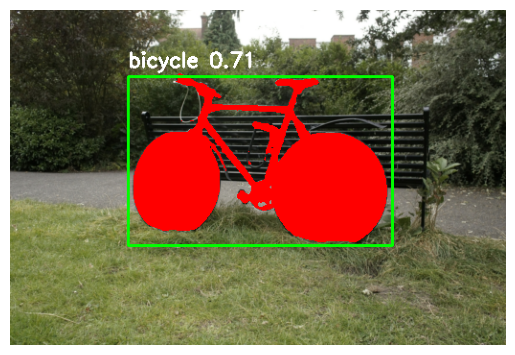

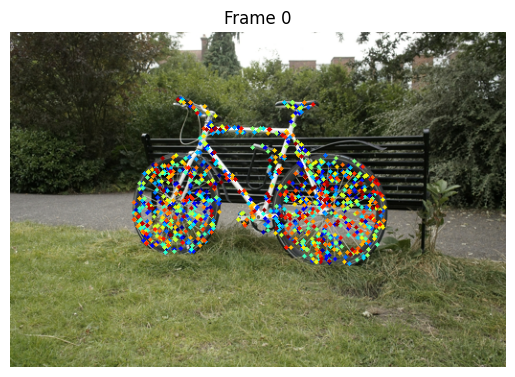

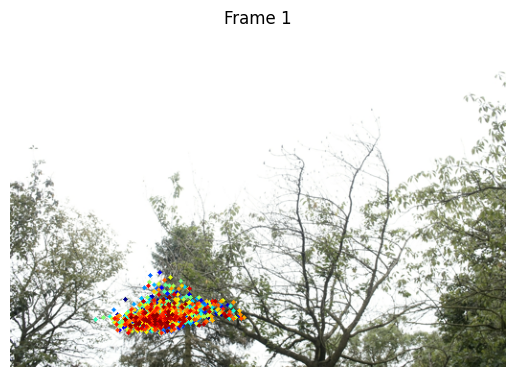

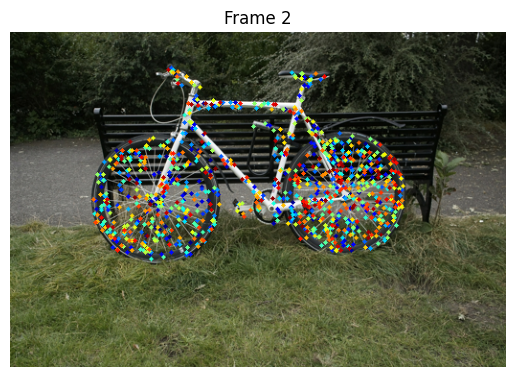

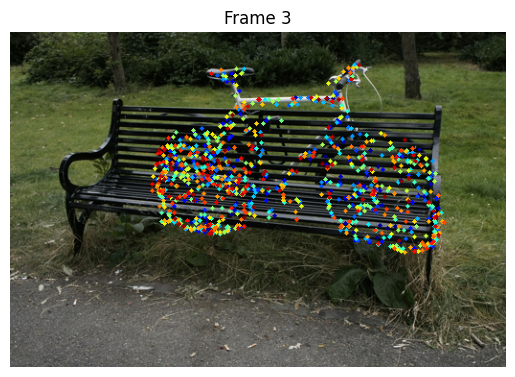

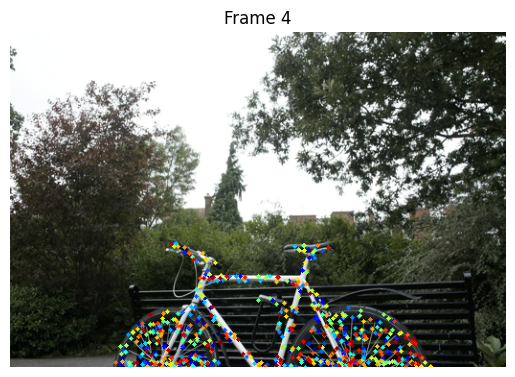

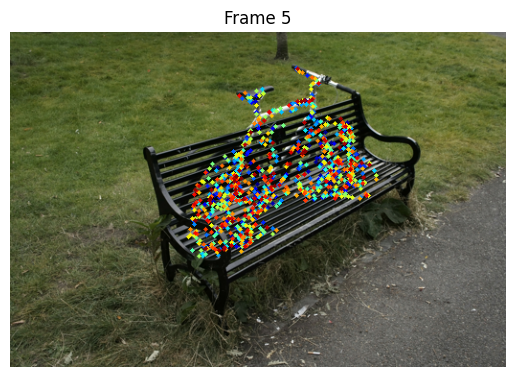

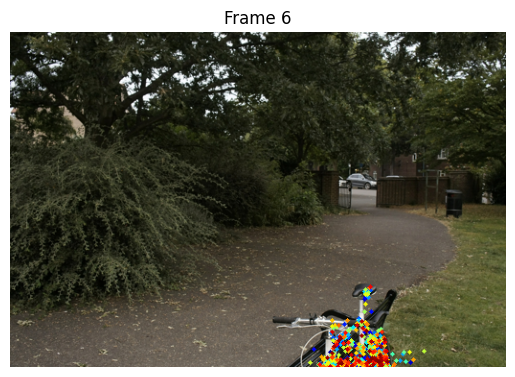

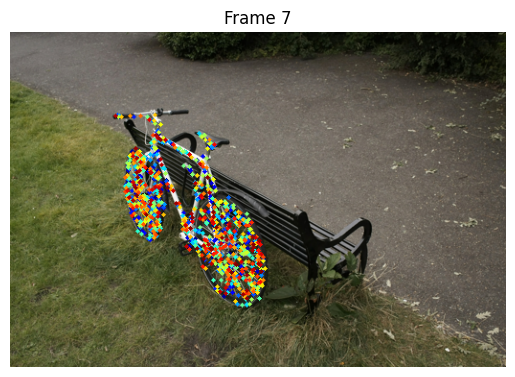

ValueError: need at least one array to concatenate

In [ ]:
# Load image
SCORE_THRESHOLD = 0.5
# image_paths = ["/home/skhalid/Documents/data/tandt_db/tandt/truck/images/000001.jpg"]
# # image_paths = ["/home/skhalid/Documents/data/nerf_synthetic/lego/images/r_0.png"]
# # image_paths = ["/home/skhalid/Documents/data/bicycle/images_4/_DSC8679.JPG"]
# # image_paths = ["/home/skhalid/Documents/data/Synthetic4Relight/hotdog/train/000.png"]
# # image_paths = ["/home/skhalid/Documents/data/data_dtu/DTU_scan24/inputs/images/000000.png"]
# # image_paths = ["/home/skhalid/Documents/data/banana/images/frame_00002.JPG"]
# image_paths = []

object_masks = []

for image_path in image_names:
    image = Image.open(image_path).convert("RGB").resize((518, 350), resample=Image.BILINEAR) # <--- match VGGT
    image_np = np.array(image)

    # Text prompt
    # texts = [["car", "bicycle", "trees", "grass", "ground", "bench", "lego", "fruit"]]  # You can modify this list
    texts = [["truck", "bicycle", "ground", "bench", "tree", "chair", "building", "sky", "clouds", "road", "lego", "grass", "toy", "hotdog", "fruit", "food", "window"]]

    # Prepare input for OWL-ViT
    inputs = processor(text=texts, images=image, return_tensors="pt").to(device)

    # Detect with OWL-ViT
    # print("Begin detect")
    with torch.no_grad():
        outputs = model(**inputs)
    # print("End detect")

    # Get boxes and scores
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=SCORE_THRESHOLD)[0]

    # Run SAM
    predictor.set_image(image_np)

    # Process each box from OWL-ViT
    for i, (box, score, label) in enumerate(zip(results["boxes"], results["scores"], results["labels"])):

        # Modify the class as needed
        if texts[0][label] == "bicycle":
            box = box.cpu().numpy().astype(int)
            x0, y0, x1, y1 = box
            print(f"{texts[0][label]}: {score:.2f} at box {box}")

            # SAM expects box in XYXY format
            input_box = np.array([x0, y0, x1, y1])
            masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)

            # Overlay mask
            mask = masks[0]
            overlay = image_np.copy()
            overlay[mask] = (255, 0, 0)  # Red mask

            # Convert mask to query points
            query_points = mask_to_query_points(mask, max_points=1000).to(device_vggt)

            # Track
            print("query_points.shape: {}".format(query_points.shape))
            print("all_images.shape: {}".format(all_images.shape))
            print("ps_idx_list: {}".format(ps_idx_list))
            print("aggregated_tokens_tensor: {}".format(aggregated_tokens_tensor.shape))
            track_list, vis_score, conf_score = model_vggt.track_head(
                aggregated_tokens_tensor, 
                all_images[None], 
                ps_idx_list[0], 
                query_points=query_points[None]
            )

            # Draw bounding box
            cv2.rectangle(overlay, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(overlay, f"{texts[0][label]} {score:.2f}", (x0, y0 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Show
            plt.imshow(overlay)
            plt.axis("off")
            plt.show()
            resized_mask = cv2.resize(mask.astype(np.uint8), (depth_conf_maps[0].shape[1], depth_conf_maps[0].shape[0]), interpolation=cv2.INTER_NEAREST)
            resized_mask = resized_mask[None, ...].astype(np.float32)
            
            # Visualize
            track_list = torch.stack(track_list)
            query_points = query_points.detach().cpu().numpy()
            visualize_tracks(all_images, track_list, query_points)

            torch.cuda.empty_cache()

            break

    object_masks.append(resized_mask)
    break

object_masks = np.concatenate((object_masks), axis=0)

In [ ]:
# print(mask.view(depth_conf_maps[0].shape[0], depth_conf_maps[0].shape[1]).shape, depth_conf_maps[0].shape)
print(mask.shape, resized_mask.shape, depth_conf_maps[0].shape, object_masks.shape)

In [30]:
N = all_intrinsics.shape[0]
MASKING_MODE = "depth"

for i in range(N):
    # filter out pixels
    if MASKING_MODE == "depth":
        conf_mask = depth_conf_maps[i]
    elif MASKING_MODE == "object":
        conf_mask = object_masks[i]
    else:
        assert MASKING_MODE == "depth" or MASKING_MODE == "object"

    conf_mask /= conf_mask.max()
    conf_mask[conf_mask<0.5] = 0.0
    conf_mask[conf_mask>0.0] = 1.0
    all_world_points[i, :] *= conf_mask[..., None]
    depth_maps[i, :] *= conf_mask[..., None]
    all_images[i, :] *= conf_mask[None, ...].astype(np.uint8)

In [ ]:
import numpy as np
import open3d as o3d
import torch

def coords_to_mask(coords_all, shape, conf_score):
    """
    Creates a binary mask from a list of 2D coordinates.

    Args:
        coords: (N, 2) tensor or array of (x, y) or (u, v) pixel coordinates.
        shape: (H, W) shape of the desired mask.

    Returns:
        mask: (H, W) binary mask with 1s at specified coordinates.
    """
    B, H, W, C = shape
    mask = torch.zeros(B, H, W, dtype=torch.bool)
    threshold = 0.1

    for b in range(B):
        coords = coords_all[b].round().long()  # Ensure integer pixel positions
        conf = conf_score[b]
        coords = coords[conf<threshold] 
        x, y = coords[:, 0], coords[:, 1]

        # Filter valid in-bounds coords
        valid = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        x, y = x[valid], y[valid]

        mask[b, y, x] = 1.0

    return mask

def show_point_clouds_batch(point_maps, images, masks=None, show_individually=False):
    """
    Generates and optionally visualizes point clouds from batched point maps and images.

    Args:
        point_maps: (N, H, W, 3)
        images: (N, H, W, 3) or (N, 3, H, W)
        masks: optional (N, H, W) binary masks
        show_individually: if True, shows each scene separately. If False, merges all into one scene.
    """
    if isinstance(point_maps, torch.Tensor):
        point_maps = point_maps.detach().cpu().numpy()
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
        if images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))  # (N, H, W, 3)

    N, H, W, _ = point_maps.shape
    pcd_list = []

    for i in range(N):
        points = point_maps[i].reshape(-1, 3)
        colors = images[i].reshape(-1, 3)
        colors = colors / 255.0 if colors.max() > 1 else colors

        if masks is not None:
            mask = masks[i].reshape(-1)
            points = points[mask > 0]
            colors = colors[mask > 0]

        # Filter invalid points
        valid_mask = np.isfinite(points).all(axis=1)
        points = points[valid_mask]
        colors = colors[valid_mask]

        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)

        if show_individually:
            o3d.visualization.draw_geometries([pcd])
        else:
            pcd_list.append(pcd)

    if not show_individually:
        o3d.visualization.draw_geometries(pcd_list)


In [93]:
track_list.shape

torch.Size([4, 1, 8, 1000, 2])

In [104]:
print(vis_score.shape)
print(vis_score.min(), vis_score.max())

torch.Size([1, 8, 1000])
tensor(0.0002, grad_fn=<MinBackward1>) tensor(0.9999, grad_fn=<MaxBackward1>)


In [95]:
conf_score.shape

torch.Size([1, 8, 1000])

In [96]:
pixel_values = track_list[0, 0, ...].detach().cpu()
print(pixel_values.shape)

torch.Size([8, 1000, 2])


In [97]:
print(all_world_points.shape)

(8, 350, 518, 3)


In [98]:
all_images.shape

(8, 3, 350, 518)

In [ ]:
masks = coords_to_mask(pixel_values, all_world_points.shape, conf_score)

In [100]:
masks.shape
print(masks.min(), masks.max())

tensor(False) tensor(True)


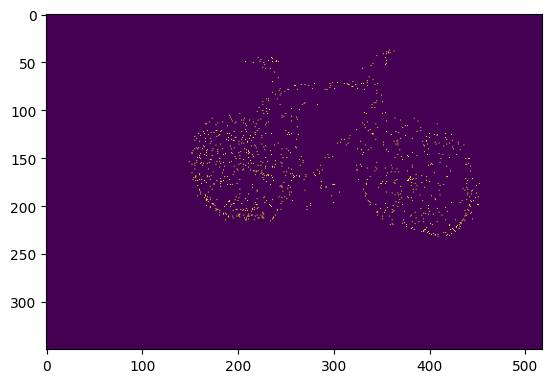

In [101]:
plt.figure()
plt.imshow(masks[3])

tensor([[[9.9974e-01, 9.9925e-01, 9.9982e-01,  ..., 9.9979e-01,
          9.9985e-01, 9.9975e-01],
         [8.1345e-04, 7.4423e-04, 7.3599e-04,  ..., 6.6202e-04,
          8.2505e-04, 8.7869e-04],
         [8.6808e-01, 8.0462e-01, 8.8299e-01,  ..., 8.6394e-01,
          9.0421e-01, 7.6389e-01],
         ...,
         [8.8530e-02, 7.8115e-01, 5.2828e-02,  ..., 5.0882e-02,
          4.7449e-02, 2.6782e-01],
         [7.5203e-04, 1.0587e-03, 4.5618e-04,  ..., 2.9022e-04,
          7.4217e-04, 7.0246e-04],
         [7.9330e-01, 6.1943e-01, 7.9661e-01,  ..., 7.9645e-01,
          8.5757e-01, 7.4337e-01]]], grad_fn=<SigmoidBackward0>)

In [102]:
show_point_clouds_batch(all_world_points, all_images, masks)

In [111]:
indx = 4
print(conf_score[0, indx].min(), conf_score[0, indx].max())

tensor(0.0002, grad_fn=<MinBackward1>) tensor(0.9651, grad_fn=<MaxBackward1>)
